In [33]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import glob
import os

In [34]:
# ====== Load data from csv ======
#df_raw = pd.read_csv("CORStaticTrial.csv", header=2)

In [41]:
# ====== 2. Extract markers  ======
csv_files = [
    os.path.join("CORDynamic1.csv"),
    os.path.join("CORDynamic2.csv"),
    os.path.join("CORStaticTrial.csv"),
]
print(f"Found {len(csv_files)} CSV files:\n")

NAME_MAP = {
    "cordynamic1.csv": ("Dynamic - Flexion/Extension", "Dynamic knee bending"),
    "cordynamic2.csv": ("Dynamic - Varus/Valgus", "Medial–lateral knee motion"),
    "corstatictrial.csv": ("Static", "Static posture; anatomical midpoint method"),
}

def infer_trial_metadata(file_path, index):
    """Infer trial type/description from filename; fallback to generic types.
    Dataset-specific override: Trials 3 and 4 are dynamic even if filenames contain 'Static'.
    """
    fname = os.path.basename(file_path).lower()

    # Defaults by index (fallback)
    defaults = {
        1: ("Dynamic - Rotation", "Rotation motion"),
        2: ("Dynamic - Varus/Valgus", "Medial-lateral motion"),
        3: ("Static - Flat Position", "Knee in extended/flat position"),
    }
    # Heuristic from filename
    if "static" in fname:
        ttype = "Static"
        desc = "Static posture (no articulation); anatomical midpoint method"
    elif any(k in fname for k in ["flex", "extension"]):
        ttype = "Dynamic - Flexion/Extension"
        desc = "Dynamic knee bending"
    elif any(k in fname for k in ["varus", "valgus", "adduction", "abduction"]):
        ttype = "Dynamic - Varus/Valgus"
        desc = "Medial-lateral knee motion"
    else:
        ttype, desc = defaults.get(index, ("Unknown", "Unspecified trial"))
    return ttype, desc

# Build trial registry
trial_info = {}
for i, f in enumerate(csv_files, 1):
    trial_name = f"Trial {i}"
    ttype, desc = infer_trial_metadata(f, i)
    trial_info[trial_name] = {"file": f, "type": ttype, "description": desc}
    print(f"  {trial_name}: {f}")
    print(f"    Type: {ttype}")
    print(f"    Description: {desc}\n")

# Load all trials into a dictionary
all_trials_data = {}
for trial_name, info in trial_info.items():
    if info["file"]:
        df = pd.read_csv(info["file"], header=2)
        all_trials_data[trial_name] = {
            "dataframe": df,
            "type": info["type"],
            "description": info["description"],
            "file": info["file"]
        }
        print(f"✓ Loaded {trial_name}: {df.shape[0]} frames, {df.shape[1]} columns")

print(f"\n✓ All {len(all_trials_data)} trials loaded successfully")

Found 3 CSV files:

  Trial 1: CORDynamic1.csv
    Type: Dynamic - Rotation
    Description: Rotation motion

  Trial 2: CORDynamic2.csv
    Type: Dynamic - Varus/Valgus
    Description: Medial-lateral motion

  Trial 3: CORStaticTrial.csv
    Type: Static
    Description: Static posture (no articulation); anatomical midpoint method

✓ Loaded Trial 1: 642 frames, 26 columns
✓ Loaded Trial 2: 867 frames, 26 columns
✓ Loaded Trial 3: 632 frames, 26 columns

✓ All 3 trials loaded successfully


In [42]:
print(df_raw.columns.tolist())

['Unnamed: 0', 'Unnamed: 1', 'CORFemur:CentrePlateMarker', 'Unnamed: 3', 'Unnamed: 4', 'CORFemur:F1', 'Unnamed: 6', 'Unnamed: 7', 'CORFemur:F2', 'Unnamed: 9', 'Unnamed: 10', 'CORFemur:F3', 'Unnamed: 12', 'Unnamed: 13', 'CORFemur:F4', 'Unnamed: 15', 'Unnamed: 16', 'CORFemur:B1', 'Unnamed: 18', 'Unnamed: 19', 'CORFemur:B2', 'Unnamed: 21', 'Unnamed: 22', 'CORFemur:B3', 'Unnamed: 24', 'Unnamed: 25']


In [43]:
# ====== 3. Compute frame and coordinates  ======
def extract_triplet(df, marker_token):
    """Extract X, Y, Z triplet for a marker from the dataframe."""
    # normalize marker_token to a list of lowercase strings
    if isinstance(marker_token, (list, tuple, set)):
        tokens = [str(t).lower() for t in marker_token]
    else:
        tokens = [str(marker_token).lower()]

    idx = None
    for i, c in enumerate(df.columns):
        cname = str(c)
        cl = cname.lower()
        if any(tok in cl for tok in tokens):
            idx = i
            break

    if idx is None:
        return None

    # make sure we have 3 consecutive columns
    if idx + 3 > len(df.columns):
        return None

    triplet_cols = df.columns[idx:idx+3]
    sub = df.loc[:, triplet_cols].copy()
    for c in triplet_cols:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    sub = sub.dropna(how="any")
    arr = sub.to_numpy(dtype=float)
    if arr.shape[1] != 3:
        return None
    return arr

# Define markers to extract
markers_to_extract = {
    "Femur": [
        "CORFemur:CentrePlateMarker", "CORFemur:F1", "CORFemur:F2", "CORFemur:F3", "CORFemur:F4" 
    ],
    "Head": [
        "CORFemur:B1", "CORFemur:B2", "CORFemur:B3" 
    ],
}

# Extract markers from each trial
trials_markers = {}

for trial_name, trial_data in all_trials_data.items():
    print(f"\n--- Processing {trial_name} ({trial_data['type']}) ---")
    df_raw = trial_data["dataframe"]
    
    data = {}
    for key, token in markers_to_extract.items():
        arr = extract_triplet(df_raw, token)
        if arr is None:
            print(f"  ❌ Could not parse {key}")
        else:
            data[key] = arr
            print(f"  ✓ {key}: {arr.shape[0]} frames")
    
    # Synchronize all markers to same number of frames
    if data:
        N = min(arr.shape[0] for arr in data.values())
        for k in data:
            data[k] = data[k][:N, :]
        
        trials_markers[trial_name] = {
            "data": data,
            "N": N,
            "type": trial_data["type"],
            "description": trial_data["description"]
        }
        print(f"  ✓ Synchronized to {N} frames")

print(f"\n✓ Marker extraction complete for all {len(trials_markers)} trials")


--- Processing Trial 1 (Dynamic - Rotation) ---
  ✓ Femur: 640 frames
  ✓ Head: 640 frames
  ✓ Synchronized to 640 frames

--- Processing Trial 2 (Dynamic - Varus/Valgus) ---
  ✓ Femur: 865 frames
  ✓ Head: 865 frames
  ✓ Synchronized to 865 frames

--- Processing Trial 3 (Static) ---
  ✓ Femur: 630 frames
  ✓ Head: 630 frames
  ✓ Synchronized to 630 frames

✓ Marker extraction complete for all 3 trials


In [44]:
# ====== SPHERE FIT (COR) This one ======
def sphere_fit(points):
    """Fit sphere to a cloud of 3D points using least squares."""
    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 3:
        raise ValueError("points must be (N,3)")
    b = np.sum(P * P, axis=1).reshape(-1, 1)
    A = np.hstack([2 * P, np.ones((P.shape[0], 1))])
    x, *_ = np.linalg.lstsq(A, b, rcond=None)
    c = x[:3, 0]
    r = float(np.sqrt(np.mean(np.sum((P - c) ** 2, axis=1))))
    return c, r

# =========================
# Process each trial (Femur & Head only)
# =========================
trials_results = {}

for trial_name, trial_markers in trials_markers.items():
    print(f"\n--- Computing {trial_name} ({trial_markers['type']}) ---")

    data = trial_markers["data"]
    N = trial_markers["N"]
    ttype = trial_markers["type"].lower()
    is_static = "static" in ttype

    # Expecting that earlier extraction returned a single (N,3) array for each:
    # - Femur: a representative femur cluster marker (e.g., CentrePlateMarker)
    # - Head:  a representative head cluster marker OR its centroid
    # If you want to use multiple head markers (B1..B3) as a cloud, compute their
    # centroid per frame upstream and store under "Head" before this step.
    if "Femur" not in data or "Head" not in data:
        print("  ❌ Missing required markers: 'Femur' and/or 'Head'")
        continue

    femur_pts = np.asarray(data["Femur"], dtype=float)  # shape (N,3)
    head_pts  = np.asarray(data["Head"], dtype=float)   # shape (N,3)

    if femur_pts.shape[0] != N or head_pts.shape[0] != N:
        n_f, n_h = femur_pts.shape[0], head_pts.shape[0]
        N_sync = min(N, n_f, n_h)
        femur_pts = femur_pts[:N_sync]
        head_pts  = head_pts[:N_sync]
        N = N_sync
        print(f"  • Resynced to {N} frames due to length mismatch")

    # Decide joint center estimation method
    if is_static:
        # Static: average the Head positions (robust to small noise)
        center = np.nanmean(head_pts, axis=0)
        r = float("nan")
        method = "anatomical/centroid-static"
        print("  ✓ Method: Head centroid (static)")
        print(f"  ✓ Joint center (mean Head): [{center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f}] mm")
        print("  • Sphere fitting skipped for static trial")
    else:
        # Dynamic: sphere-fit the Head trajectory in global coords
        # If you have multiple head markers upstream, concatenate them there
        # and pass their centroid per frame into 'Head', or build a bigger point
        # cloud and sphere_fit that instead.
        valid = np.isfinite(head_pts).all(axis=1)
        head_cloud = head_pts[valid]
        if head_cloud.shape[0] < 5:
            print("  ❌ Not enough valid head points for sphere fit; falling back to mean.")
            center = np.nanmean(head_pts, axis=0)
            r = float("nan")
            method = "fallback-mean"
        else:
            center, r = sphere_fit(head_cloud)
            method = "sphere-fit"
        print(f"  ✓ Method: {method.replace('-', ' ')} (dynamic)")
        print(f"  ✓ Joint center estimated at: [{center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f}] mm")
        if np.isfinite(r):
            print(f"  ✓ Sphere radius: {r:.2f} mm")

    # Use middle frame as reference for distances to Femur
    frame = N // 2
    femur_origin = femur_pts[frame]

    # Distances and local coords relative to Femur origin (no Femur rotation available here)
    delta_femur = center - femur_origin
    distance_femur_COR = float(np.linalg.norm(delta_femur))

    trials_results[trial_name] = {
        "data": data,
        "N": N,
        "type": trial_markers["type"],
        "description": trial_markers["description"],
        "method": method,
        "center": center,               # global coordinates
        "radius": r,                    # sphere-fit radius (dynamic) or NaN (static)
        "frame": frame,
        "femur_origin": femur_origin,   # femur reference point at mid-frame
        "delta_femur": delta_femur,     # vector from femur origin to center
        "distance_femur_COR": distance_femur_COR,
    }

print(f"\n✓ Analysis complete for all {len(trials_results)} trials")


--- Computing Trial 1 (Dynamic - Rotation) ---
  ✓ Method: sphere fit (dynamic)
  ✓ Joint center estimated at: [17.25, 416.30, 25.05] mm
  ✓ Sphere radius: 2.20 mm

--- Computing Trial 2 (Dynamic - Varus/Valgus) ---
  ✓ Method: sphere fit (dynamic)
  ✓ Joint center estimated at: [17.80, 415.29, 24.46] mm
  ✓ Sphere radius: 1.49 mm

--- Computing Trial 3 (Static) ---
  ✓ Method: Head centroid (static)
  ✓ Joint center (mean Head): [17.44, 414.68, 23.93] mm
  • Sphere fitting skipped for static trial

✓ Analysis complete for all 3 trials


In [45]:
# ====== 5. PRINT SUMMARY ======
print("=" * 80)
print("FEMUR–HEAD JOINT CENTER ANALYSIS - SUMMARY OF ALL TRIALS")
print("=" * 80)

for trial_name, results in trials_results.items():
    print(f"\n{'=' * 80}")
    print(f"  {trial_name}: {results['type']}")
    print(f"  Method: {results['method']}")
    print(f"  {results['description']}")
    print(f"{'=' * 80}")
    print(f"Frames analyzed: {results['N']}")
    print(f"Reference frame: {results['frame']} (middle frame)")
    print()
    print(f"Joint Center (COR) in lab coordinates:")
    print(f"  Position: [{results['center'][0]:.3f}, {results['center'][1]:.3f}, {results['center'][2]:.3f}] mm")

    rad = results['radius']
    if isinstance(rad, float) and np.isfinite(rad):
        print(f"  Sphere radius: {rad:.3f} mm")
    else:
        print("  Sphere radius: N/A (static/anatomical method)")

    print()
    print(f"Distance from Femur origin to COR: {results['distance_femur_COR']:.3f} mm")
    print(f"Δ (Femur → COR) [X,Y,Z]: "
          f"[{results['delta_femur'][0]:.3f}, {results['delta_femur'][1]:.3f}, {results['delta_femur'][2]:.3f}] mm")

print(f"\n{'=' * 80}")
print("COMPARISON SUMMARY")
print(f"{'=' * 80}")
print(f"{'Trial':<15} {'Type':<30} {'Method':<20} {'COR X':<10} {'COR Y':<10} {'COR Z':<10} {'Radius':<10}")
print("-" * 80)

for trial_name, results in trials_results.items():
    rad = results['radius']
    rad_str = f"{rad:>9.2f}" if (isinstance(rad, float) and np.isfinite(rad)) else f"{'N/A':>9}"
    print(f"{trial_name:<15} {results['type']:<30} {results['method']:<20} "
          f"{results['center'][0]:>9.2f} {results['center'][1]:>9.2f} {results['center'][2]:>9.2f} {rad_str}")

print("=" * 80)

FEMUR–HEAD JOINT CENTER ANALYSIS - SUMMARY OF ALL TRIALS

  Trial 1: Dynamic - Rotation
  Method: sphere-fit
  Rotation motion
Frames analyzed: 640
Reference frame: 320 (middle frame)

Joint Center (COR) in lab coordinates:
  Position: [17.252, 416.297, 25.046] mm
  Sphere radius: 2.196 mm

Distance from Femur origin to COR: 225.865 mm
Δ (Femur → COR) [X,Y,Z]: [-123.871, -12.433, -188.458] mm

  Trial 2: Dynamic - Varus/Valgus
  Method: sphere-fit
  Medial-lateral motion
Frames analyzed: 865
Reference frame: 432 (middle frame)

Joint Center (COR) in lab coordinates:
  Position: [17.798, 415.294, 24.455] mm
  Sphere radius: 1.491 mm

Distance from Femur origin to COR: 234.955 mm
Δ (Femur → COR) [X,Y,Z]: [-155.345, 34.549, -172.853] mm

  Trial 3: Static
  Method: anatomical/centroid-static
  Static posture (no articulation); anatomical midpoint method
Frames analyzed: 630
Reference frame: 315 (middle frame)

Joint Center (COR) in lab coordinates:
  Position: [17.441, 414.676, 23.927] mm


Generating 3D visualization for Trial 1...


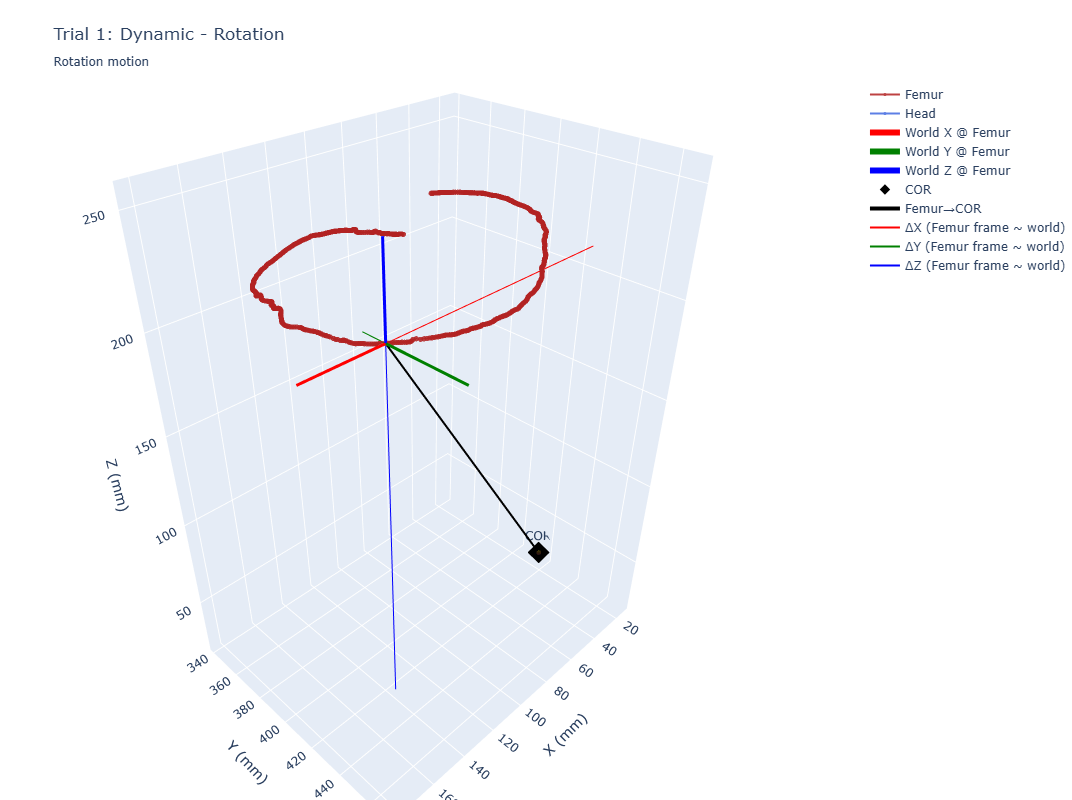


Generating 3D visualization for Trial 2...


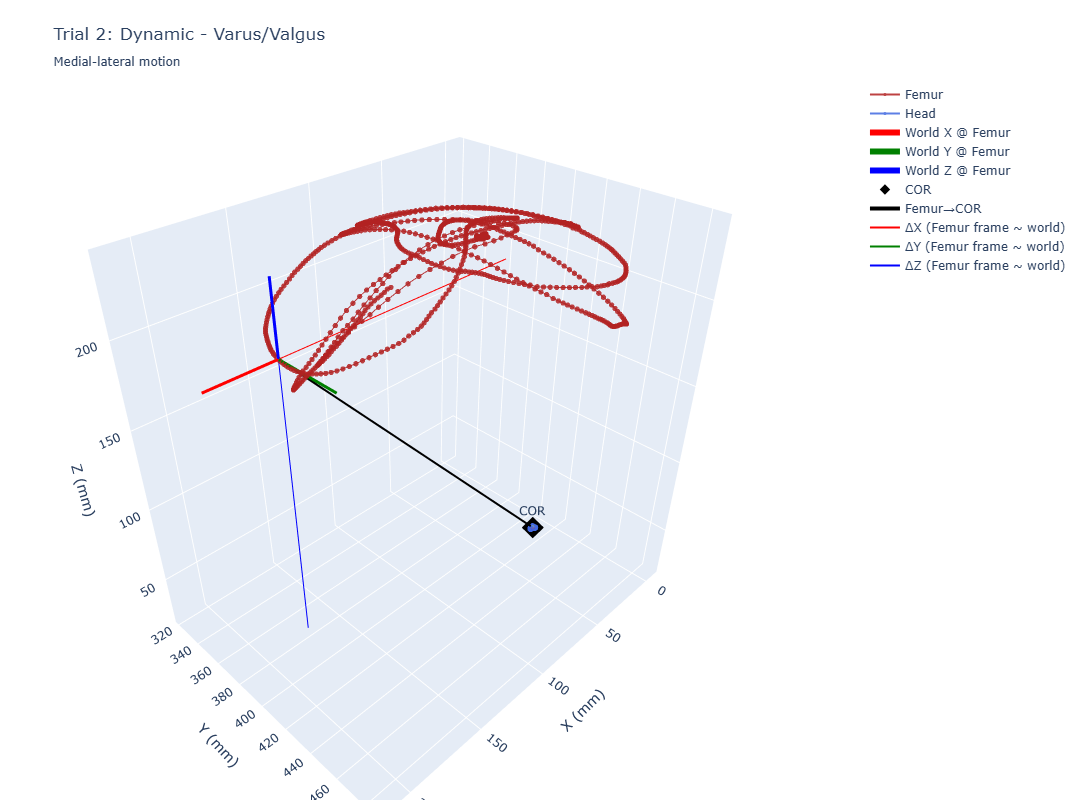


Generating 3D visualization for Trial 3...


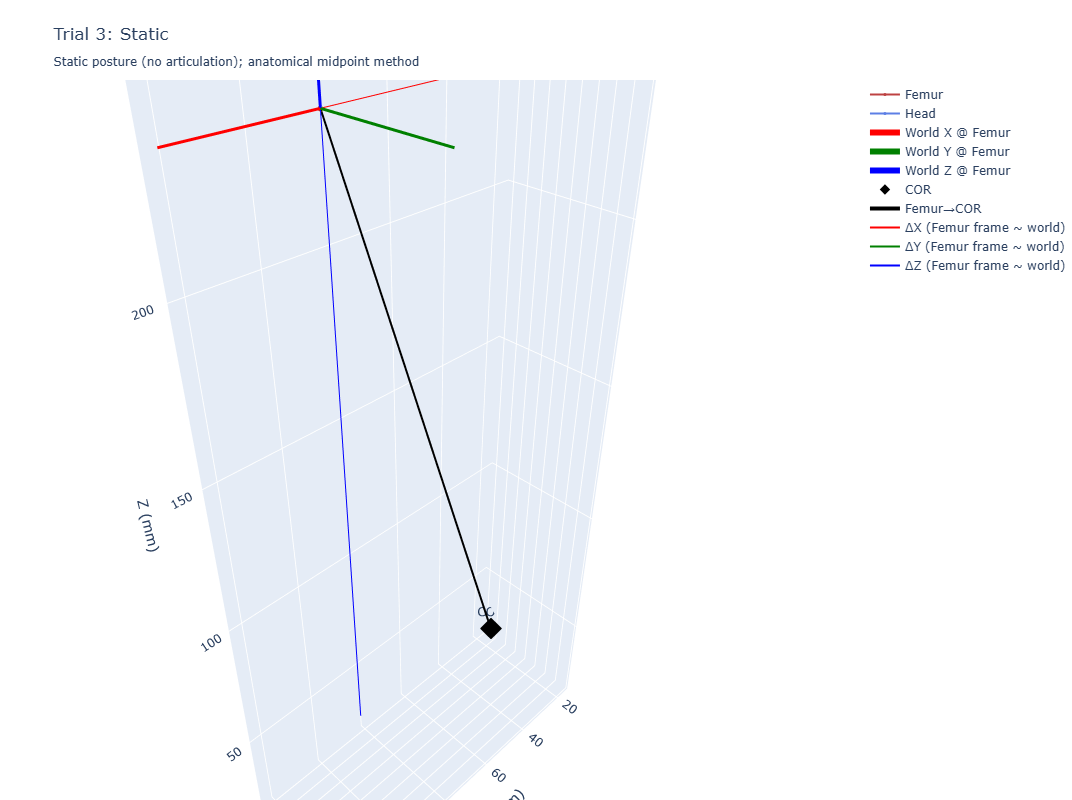


✓ All visualizations generated


In [47]:
# ====== 6. 3D VISUALIZATION ======
def trace_points(name, pts, color, size=3, mode='markers'):
    """Create 3D scatter/path for (N,3) points."""
    return go.Scatter3d(
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        mode=mode,
        marker=dict(size=size, color=color),
        line=dict(width=2, color=color),
        name=name,
        opacity=0.85,
        connectgaps=True
    )

def trace_arrow(name, origin, vec, color, width=6):
    """Create line trace for vector arrow."""
    p2 = origin + vec
    return go.Scatter3d(
        x=[origin[0], p2[0]],
        y=[origin[1], p2[1]],
        z=[origin[2], p2[2]],
        mode='lines',
        line=dict(width=width, color=color),
        name=name
    )

def sphere_surface(center, radius, res=24):
    """Create semi-transparent sphere surface."""
    u = np.linspace(0, 2*np.pi, res)
    v = np.linspace(0, np.pi, res)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones_like(u), np.cos(v))
    return go.Surface(x=x, y=y, z=z, opacity=0.25, showscale=False, name='COR sphere')

# Create visualization for each trial
for trial_name, results in trials_results.items():
    print(f"\nGenerating 3D visualization for {trial_name}...")

    data = results["data"]
    center = results["center"]
    r = results["radius"]
    femur_origin = results["femur_origin"]
    delta_femur = results["delta_femur"]

    traces = []

    # Plot clusters (as trajectories)
    if "Femur" in data:
        traces.append(trace_points("Femur", np.asarray(data["Femur"]), "firebrick", size=3, mode='lines+markers'))
    if "Head" in data:
        traces.append(trace_points("Head", np.asarray(data["Head"]), "royalblue", size=3, mode='lines+markers'))

    # World axes shown at the femur origin (for orientation)
    axis_scale = 40.0
    traces += [
        trace_arrow("World X @ Femur", femur_origin, np.array([axis_scale, 0, 0]), "red"),
        trace_arrow("World Y @ Femur", femur_origin, np.array([0, axis_scale, 0]), "green"),
        trace_arrow("World Z @ Femur", femur_origin, np.array([0, 0, axis_scale]), "blue"),
    ]

    # Center of rotation and optional sphere
    traces.append(
        go.Scatter3d(
            x=[center[0]], y=[center[1]], z=[center[2]],
            mode='markers+text',
            marker=dict(size=8, color='black', symbol='diamond'),
            text=["COR"],
            textposition="top center",
            name="COR"
        )
    )
    if isinstance(r, float) and np.isfinite(r) and r > 1e-6:
        traces.append(sphere_surface(center, r))

    # Connection line Femur origin → COR
    traces.append(trace_arrow("Femur→COR", femur_origin, center - femur_origin, "black", width=4))

    # Per-axis component vectors (from Femur origin)
    traces += [
        trace_arrow("ΔX (Femur frame ~ world)", femur_origin, np.array([delta_femur[0], 0, 0]), "red", width=2),
        trace_arrow("ΔY (Femur frame ~ world)", femur_origin, np.array([0, delta_femur[1], 0]), "green", width=2),
        trace_arrow("ΔZ (Femur frame ~ world)", femur_origin, np.array([0, 0, delta_femur[2]]), "blue", width=2),
    ]

    layout = go.Layout(
        scene=dict(
            xaxis_title="X (mm)",
            yaxis_title="Y (mm)",
            zaxis_title="Z (mm)",
            aspectmode='data',
            xaxis=dict(showspikes=False),
            yaxis=dict(showspikes=False),
            zaxis=dict(showspikes=False)
        ),
        title=f"{trial_name}: {results['type']}<br><sub>{results['description']}</sub>",
        showlegend=True,
        height=800,
        width=1000,
        margin=dict(l=0, r=0, t=80, b=0)
    )

    fig = go.Figure(data=traces, layout=layout)
    fig.show()

print("\n✓ All visualizations generated")
